# Create Datasets from audio files

In [0]:
! pip install soundfile

In [0]:
import os

import numpy as np
import matplotlib.pyplot as plt

import soundfile

from IPython.display import Audio as audio_playback_widget

Cloning into 'colab_helper'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 277 (delta 64), reused 73 (delta 31), pack-reused 171
Receiving objects: 100% (277/277), 57.87 KiB | 331.00 KiB/s, done.
Resolving deltas: 100% (169/169), done.


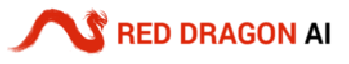

In [0]:
! git clone https://github.com/mdda/colab_helper
from colab_helper import utils as chu

In [0]:
chu.download('http://redcatlabs.com/downloads/'
             +'deep-learning-workshop/notebooks/2-CNN/8-Speech/'
             +'data-num-sounds.tar.gz', dest_path='data')

Uncompressing .tar.gz : './data-num-sounds.tar.gz'
Deleting './data-num-sounds.tar.gz'
'./data' now contains data


In [0]:
! ls -l 


total 12
drwxr-xr-x 6 root root 4096 Feb 11 05:03 colab_helper
drwxr-xr-x 3 root root 4096 Feb 11 05:03 data
drwxr-xr-x 1 root root 4096 Feb  5 18:37 sample_data


In [0]:
# ! mv data-tmp data

In [0]:
f = './data/raw-from-phone.wav'
#f = './data/num_phone_en-UK_m_Martin15.wav'

### Normally an audio file needs clipping at the beginning/end

The following let's us examine the audio input, and choose the region of interest (in seconds from the start of the input audio file)

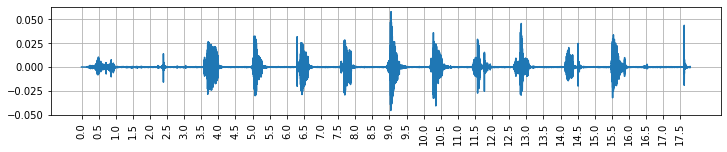

In [0]:
# Read in the original file
samples, sample_rate = soundfile.read(f)

def show_waveform(sound):
    n_samples = sound.shape[0]

    plt.figure(figsize=(12,2))
    plt.plot(np.arange(0.0, n_samples)/sample_rate, sound)
    plt.xticks( np.arange(0.0, n_samples/sample_rate, 0.5), rotation=90 )

    plt.grid(True)

    plt.show()

show_waveform(samples)
audio_playback_widget(f) # v. quiet though!

Now, let's select the region of interest

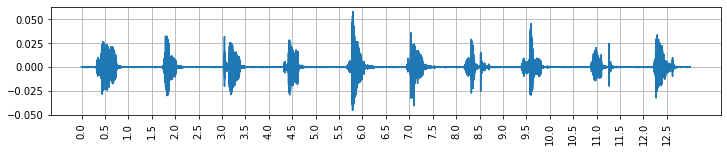

In [0]:
crop = (3.25, 16.25)  # in seconds (from waveform graph above)

cropped = samples[ int(crop[0]*sample_rate):int(crop[1]*sample_rate) ]

show_waveform(cropped)

When satisfied, write the file to disk - and update the name as appropriate (it's also possible to over-write the existing file).

Be **careful** with this step.

In [0]:
#Only do this (set it to 1) if you want to replace the file with the cropped version...
if 0:
    f = './data/cropped-raw-from-phone.wav'  
    soundfile.write(f, cropped, samplerate=sample_rate)
    print("Wrote '%s'" % (f,))

## Now look at the audio spectrograms

First, we'll do this 'by hand', so that the code is laid out clearly.

In [0]:
f = './data/num_phone_en-UK_m_Martin00.wav'
#f = './data/num_Bing_en-UK_f_Susan.wav'

#f = './data/animals_phone_en-UK_m_Martin02.wav'

#f = './data/num_phone_en-UK_m_Martin00.ogg'
#f = './data/num_Bing_en-UK_f_Susan.ogg'

The following defines a function that does the spectrogram (FFT, etc), and then we define a smoothing function that will help us segment the audio into words later.

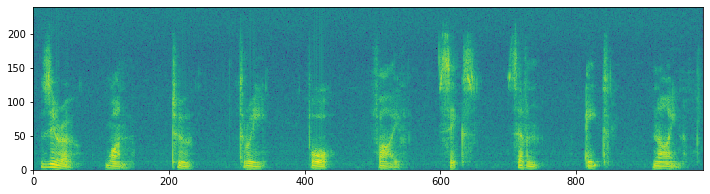

In [0]:
def spectrogram(wav_filepath):
    samples, sample_rate = soundfile.read(wav_filepath)

    # Original code from :
    # https://mail.python.org/pipermail/chicago/2010-December/007314.html

    # Rescale so that max/min are ~ +/- 1 around 0
    data_av = np.mean(samples)
    data_max = np.max(np.absolute(samples-data_av))
    sound_data = (samples - data_av)/data_max
    
    ## Parameters: 10ms step, 30ms window
    nstep = int(sample_rate * 0.01)
    nwin  = int(sample_rate * 0.03)
    nfft = 2*int(nwin/2)

    window = np.hamming(nwin)

    # will take windows x[n1:n2].  generate and loop over 
    # n2 such that all frames fit within the waveform
    nn = range(nwin, len(sound_data), nstep)

    X = np.zeros( (len(nn), nfft//2) )

    for i,n in enumerate(nn):
        segment = sound_data[ n-nwin:n ]
        z = np.fft.fft(window * segment, nfft)
        X[i,:] = np.log(np.absolute(z[:nfft//2]))
        
    return X
 
plt.figure(figsize=(12,3))
plt.imshow(spectrogram(f).T, interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

audio_playback_widget(f)

In [0]:
# This is a function that smooths a time-series
#   which enables us to segment the input into words by looking at the 'energy' profile
def smooth(x, window_len=31):  # , window='hanning'
    # http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    #s = np.r_[ x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    s = np.r_[ np.zeros( ((window_len-1)//2,) ), x, np.zeros( ((window_len-1)//2,) ) ]
    w=np.hamming(window_len)
    return np.convolve(w/w.sum(), s, mode='valid') #[window_len-1 : -(window_len-1) ]

X.shape= (987, 240)
Y.shape= (987,)
Y_crop.shape= (987,)


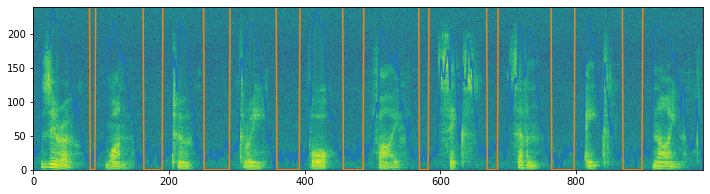

575.5524193548387 405.53225806451616


In [0]:
X = spectrogram(f)
print("X.shape=", X.shape)

#Y = np.std(X, axis=1)
Y = np.max(X, axis=1)
Y_min = np.min(Y)
Y_range = Y.max()-Y_min
Y = (Y - Y_min)/Y_range

print("Y.shape=", Y.shape)

Y_crop = np.where(Y>0.25, 1.0, 0.0)

# Apply some smoothing
Y_crop = smooth(Y_crop)

Y_crop = np.where(Y_crop>0.01, 1.0, 0.0)
print("Y_crop.shape=", Y_crop.shape)

plt.figure(figsize=(12,3))
plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(left=0)
plt.ylim(bottom=0)

plt.plot(Y * X.shape[1])

plt.plot(Y_crop * X.shape[1])

plt.show()
#Y.min(), Y.max()
#X[100,:]
print( np.argmin(X)/248, np.argmax(X)/248 )

audio_playback_widget(f)

Work out the contiguous region of high enery (== sound) so that we can split the file into voiced segments.

In [0]:
#http://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array
def contiguous_regions(condition):
    idx = []
    i = 0
    while i < len(condition):
        x1 = i + condition[i:].argmax()
        try:
            x2 = x1 + condition[x1:].argmin()
        except:
            x2 = x1 + 1
        if x1 == x2:
            if condition[x1] == True:
                x2 = len(condition)
            else:
                break
        idx.append( [x1,x2] )
        i = x2
    return idx

contiguous_regions(Y_crop>0.5)

[[0, 84],
 [92, 163],
 [191, 252],
 [290, 359],
 [393, 457],
 [487, 569],
 [583, 669],
 [685, 764],
 [798, 869],
 [898, 987]]

### Next : Think about lists of words for the datasets

In [0]:
import re
remove_punc = re.compile('[\,\.\?\!]')
squash_spaces = re.compile('\s+')
def words(s):
    s = remove_punc.sub(' ', s)
    s = squash_spaces.sub(' ', s)
    return s.strip().lower()

sentences=dict(
    num=words("zero one two three four five six seven eight nine."),
    
    animals=words("cat dog fox bird."),
    
    # https://www.quora.com/Is-there-a-text-that-covers-the-entire-English-phonetic-range/
    qbf=words("That quick beige fox jumped in the air over each thin dog.  "+
              "Look out, I shout, for he's foiled you again, creating chaos."),
    shy=words("Are those shy Eurasian footwear, cowboy chaps, "+
              "or jolly earthmoving headgear?"),
    ate=words("The hungry purple dinosaur ate the kind, zingy fox, the jabbering crab, "+
              "and the mad whale and started vending and quacking."),
    suz=words("With tenure, Suzie'd have all the more leisure for yachting, "+
              "but her publications are no good."),
    tbh=words("Shaw, those twelve beige hooks are joined if I patch a young, gooey mouth."),
    
    #  https://en.wikipedia.org/wiki/The_North_Wind_and_the_Sun          #594
    #  http://videoweb.nie.edu.sg/phonetic/courses/aae103-web/wolf.html  #1111
)
sentences['num']

'zero one two three four five six seven eight nine'

We can also generate voices synthetically - and Bing has a nice interface for that at https://www.microsoft.com/cognitive-services/en-us/speech-api

In [0]:
def for_msft(prefixes):  # comma separated
    return ' '.join([sentences[a] for a in prefixes.split(',')]).replace(' ', '\n') 
"""
This is the SSML that will be sent to the service:
<speak version="1.0" xmlns="http://www.w3.org/2001/10/synthesis" 
      xmlns:mstts="http://www.w3.org/2001/mstts" xml:lang="en-GB">
  <voice xml:lang="en-GB" name="Microsoft Server Speech Text to Speech Voice (en-GB, Susan, Apollo)">
zero
one
two
three
four
five
six
seven
eight
nine
  </voice>
</speak>
"""

# https://www.microsoft.com/cognitive-services/en-us/Speech-api/documentation/API-Reference-REST/BingVoiceOutput
a=for_msft('num')  # 49 long...
#a=for_msft('qbf,shy,ate,suz,tbh')  # 474 long...

print("length_in_chars=%d\n%s" % (len(a),a,))

length_in_chars=49
zero
one
two
three
four
five
six
seven
eight
nine


If you want to do some manipulations on raw audio in Linux, ```sox``` is the perfect tool.

In [0]:
# sox_ogg_param='--rate 16000 --channels 1'
# sox_wav_param="${sox_ogg_param} --encoding signed-integer"

# sox english.au ${sox_wav_param} english.wav norm -3
# sox english.au ${sox_ogg_param} english.ogg norm -3

### Now use 'proper' audio tools for segmentation

In [0]:
! pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=1f15d5e044dae7d0804b3332022f18de4f56ded5cb3b9ab1c20336fa495941fe
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
# pip install python_speech_features
import python_speech_features

sample_window_step = 0.01 # in seconds (10ms)

def get_sample_features(samples, sample_rate):
    #sample_feat = python_speech_features.mfcc(samples, sample_rate, numcep=13, nfilt=26, appendEnergy=True)
    #sample_feat = python_speech_features.mfcc(samples, sample_rate, numcep=28, nfilt=56, appendEnergy=True)

    #sample_feat, e = python_speech_features.fbank(samples,samplerate=sample_rate,
    #      winlen=0.025,winstep=0.01,nfilt=26,nfft=512,
    #      lowfreq=0,highfreq=None,preemph=0.97, winfunc=lambda x:np.ones((x,)))

    features, energy = python_speech_features.fbank(samples, samplerate=sample_rate, 
                            winlen=0.025, winstep=sample_window_step, 
                            nfilt=32,nfft=512,
                            lowfreq=0,highfreq=None,preemph=0.25,
                            winfunc=lambda x:np.hamming( x ))
    return features, energy
    
def get_sample_isolated_words(energy, plot=False):
    log_e = np.log(energy)
    if plot: plt.plot(log_e-5)

    #log_e = smooth(log_e)
    #if plot: plt.plot(log_e)
    
    log_e_hurdle = (log_e.max() - log_e.min())*0.25 + log_e.min()

    log_e_crop = np.where(log_e>log_e_hurdle, 1.0, 0.0)
    if plot: plt.plot(log_e_crop * 25 - 2.5)

    # By smoothing, and applying a very low hurdle, we expand the crop area safely
    log_e_crop_expanded = np.where( smooth(log_e_crop, )>0.01, 1.0, 0.0)
    if plot: plt.plot(log_e_crop_expanded * 30 -5)
    
    return contiguous_regions(log_e_crop_expanded>0.5)

Redo the calculation above, but using the 'proper' tools.  Notice how the scaling, contrast, etc, are better 'looking'.  

Actually, the 'look' is something that we actually care about here.

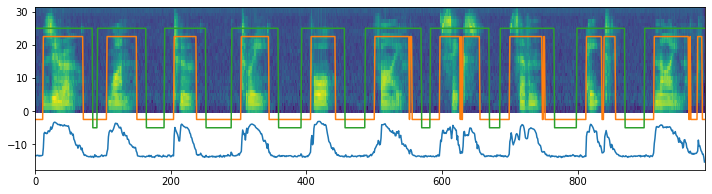

(988, 32) (988,) 0.00023496673861778835


In [0]:
samples, sample_rate = soundfile.read(f)

sample_feat, energy = get_sample_features(samples, sample_rate)

plt.figure(figsize=(12,3))
plt.imshow(np.log(sample_feat.T), interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(xmin=0)

word_ranges = get_sample_isolated_words(energy, plot=True)

plt.show()

print(sample_feat.shape, energy.shape, energy[10])
audio_playback_widget(f)

## Building the dataset : in steps

Break sound into separate WAVs in word-based directories

In [0]:
def split_combined_file_into_wavs(f, prefix='num'):
    # f ~ './data/num_Bing_en-UK_f_Susan.wav'
    f_base_orig = os.path.basename( f )
    if not f_base_orig.startswith(prefix+"_"): 
        print("Wrong prefix for '%s'" % (f_base_orig,))
        return
    
    # Here's the new filename (directory to be calculated per-word)
    f_base = os.path.splitext(f_base_orig)[0][len(prefix)+1:] + '.wav'
    
    samples, sample_rate = soundfile.read(f)
    sample_feat, energy = get_sample_features(samples, sample_rate)
    word_ranges = get_sample_isolated_words(energy, plot=False)
    #print(word_ranges)
    
    words = sentences[prefix].split(' ')
    if len(word_ranges) != len(words):
        print("Found %d segments, rather than %d, in '%s'" % (len(word_ranges), len(words), f,))
        return
    
    for i, word in enumerate(words):
        word_path = os.path.join('data', prefix, word)
        os.makedirs(word_path, exist_ok=True)
        
        wr = word_ranges[i]
        fac = int(sample_window_step*sample_rate)
        soundfile.write(os.path.join(word_path, f_base), samples[ wr[0]*fac:wr[1]*fac ], samplerate=sample_rate)

In [0]:
split_combined_file_into_wavs('./data/num_Bing_en-UK_f_Susan.wav')
#split_combined_file_into_wavs('./data/num_phone_en-UK_m_Martin00.wav')

### Iterate through all the audio files with a given prefix, and unfold them

In [0]:
def split_all_combined_files_into_wavs(prefix='num'):
    for audio_file in sorted(os.listdir( './data' )):
        filename_stub, ext = os.path.splitext(audio_file)
        if not (ext=='.wav' or ext=='.ogg'): continue
        if not filename_stub.startswith( prefix+'_'): continue
    
        print("Splitting %s" % (audio_file,))
        split_combined_file_into_wavs( './data/'+audio_file, prefix=prefix)

In [0]:
split_all_combined_files_into_wavs(prefix='num')

Splitting num_Bing_en-AU_f_Catherine.wav
Splitting num_Bing_en-CA_f_Linda.wav
Splitting num_Bing_en-IN_m_Ravi.wav
Splitting num_Bing_en-UK_f_Susan.ogg
Splitting num_Bing_en-UK_f_Susan.wav
Splitting num_Bing_en-UK_m_George.wav
Splitting num_Bing_en-US_f_Zira.wav
Splitting num_Bing_en-US_m_Benjamin.wav
Splitting num_phone_en-UK_m_Martin00.ogg
Splitting num_phone_en-UK_m_Martin00.wav
Splitting num_phone_en-UK_m_Martin01.wav
Splitting num_phone_en-UK_m_Martin02.wav
Splitting num_phone_en-UK_m_Martin03.wav
Splitting num_phone_en-UK_m_Martin04.wav
Splitting num_phone_en-UK_m_Martin05.wav
Splitting num_phone_en-UK_m_Martin06.wav
Splitting num_phone_en-UK_m_Martin07.wav
Splitting num_phone_en-UK_m_Martin08.wav
Splitting num_phone_en-UK_m_Martin09.wav
Splitting num_phone_en-UK_m_Martin10.wav
Splitting num_phone_en-UK_m_Martin11.wav
Splitting num_phone_en-UK_m_Martin12.wav
Splitting num_phone_en-UK_m_Martin13.wav
Splitting num_phone_en-UK_m_Martin14.wav
Splitting num_phone_en-UK_m_Martin15.wav


### Convert WAVs to 'stamps'

Now we have some nice WAV files placed into folders which are named according to the word inside, let's create a function that preprocesses the audio clips into 'stamp' files that are essentially spectrograms with a fixed size (and ```uint8``` data type - which makes the ```numpy``` array small).

In [0]:
# Convert a given (isolated word) WAV into a 'stamp' - using a helper function
from PIL import Image

def samples_to_stamp(samples, sample_rate):
    sample_feat, energy = get_sample_features(samples, sample_rate)
    
    data = np.log(sample_feat)
    
    # Now normalize each vertical slice so that the minimum energy is ==0
    data_mins = np.min(data, axis=1)
    data_min0 = data - data_mins[:, np.newaxis]
    
    # Force the data into the 'stamp size' as an image (implicit range normalization occurs)
    stamp = np.array(Image.fromarray(data_min0).resize( (64,32), resample=Image.BILINEAR ))
    
    # https://github.com/scipy/scipy/issues/4458 :: The stamps are stored as uint8...
    return stamp

def wav_to_stamp(prefix, word, wav):
    samples, sample_rate = soundfile.read( os.path.join('data', prefix, word, wav) )
    return samples_to_stamp(samples, sample_rate)

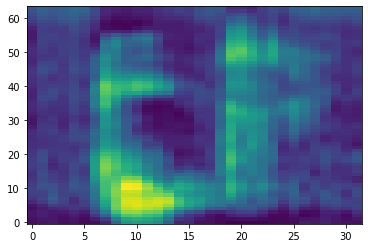

0.0016146669 11.297018


In [0]:
# Show what the 'visual stamp' for a given word looks like
stamp = wav_to_stamp('num', 'eight', 'phone_en-UK_m_Martin00.wav')

plt.imshow(stamp.T, interpolation='nearest', origin='lower', aspect='auto')
plt.show()

print( np.min(stamp), np.max(stamp) )
audio_playback_widget( os.path.join('data', 'num', 'eight', 'phone_en-UK_m_Martin00.wav') )

### Collect the WAVs into a 'stamp' dataset

In [0]:
# combine all words from a given prefix into a dataset of 'stamps'
import pickle

def create_dataset_from_folders(prefix, save_as='.pkl', seed=13):
    words = sentences[prefix].split(' ')
    stamps, labels = [], []
    
    for label_i, word in enumerate( words ):
        # Find all the files for this word
        for stamp_file in os.listdir( os.path.join('data', prefix, word )):
            if not f.endswith('.wav'): continue
            #print(stamp_file)
            stamp = wav_to_stamp(prefix, word, stamp_file)
            
            stamps.append(stamp)
            labels.append(label_i)

    if save_as is None: # Return the data directly
        return stamps, labels, words
    
    np.random.seed(seed)
    data_dictionary = dict(
        stamp=stamps, label=labels, 
        rand=np.random.rand( len(labels) ), # This is to enable us to sample the data (based on hurdles)
        words=words, 
    )
    ds_file = os.path.join('data', prefix+save_as)
    pickle.dump(data_dictionary, open(ds_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print("Created dataset : %s" % (ds_file, ))    

In [0]:
#if not os.path.exists('data/num.pkl'):
if True:
    create_dataset_from_folders('num')

Created dataset : data/num.pkl


### Test that the dataset can be read back

In [0]:
# Read in the dataset
dataset = pickle.load(open(os.path.join('data', 'num.pkl'), 'rb'))

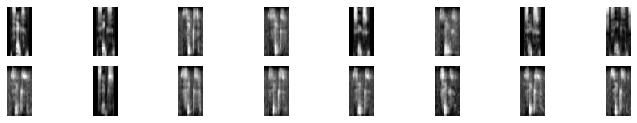

In [0]:
# Plot all of a given 'word'
indices = [ i for i,label in enumerate(dataset['label']) if dataset['words'][label]=='six']

plt.figure(figsize=(12, 2))
for pos, i in enumerate(indices[0:16]):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(dataset['stamp'][i].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

### Enable 'ad-hoc' look-see testing

This allows us to just pop single words, etc, into a folder, and have them labelled with the filename only (no actual label).  This is really just for show-and-tell.

In [0]:
# Now do something similar for 'test files', create a dataset for all the audio files in the given folder

def create_dataset_from_adhoc_wavs(prefix, save_as='.pkl', seed=13):
    stamps, labels, words = [], [], []
    
    for audio_file in sorted(os.listdir( os.path.join('data', prefix) )):
        filename_stub, ext = os.path.splitext(audio_file)
        if not (ext=='.wav' or ext=='.ogg'): continue
            
        samples, sample_rate = soundfile.read( os.path.join('data', prefix, audio_file) )
        sample_feat, energy = get_sample_features(samples, sample_rate)
        word_ranges = get_sample_isolated_words(energy, plot=False)
    
        for i, wr in enumerate(word_ranges):
            wr = word_ranges[i]
            fac = int(sample_window_step*sample_rate)
            segment = samples[ wr[0]*fac:wr[1]*fac ]

            stamp = samples_to_stamp(segment, sample_rate)
            
            print("Adding : %s #%2d : (%d,%d)" % (filename_stub, i, wr[0], wr[1],))
            stamps.append(stamp)
            labels.append(-1)
            words.append("%s_%d" % (filename_stub, i))
    
    np.random.seed(seed)
    data_dictionary = dict(
        stamp=stamps, label=labels, 
        rand=np.random.rand( len(labels) ),
        words=words, 
    )
    ds_file = os.path.join('data', prefix+save_as)
    pickle.dump(data_dictionary, open(ds_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print("Created dataset : %s" % (ds_file, ))

In [0]:
test_prefix = 'num' +'-test'

In [0]:
create_dataset_from_adhoc_wavs(test_prefix)

Adding : Martin-Digits # 0 : (0,128)
Adding : Martin-Digits # 1 : (141,237)
Adding : Martin-Digits # 2 : (253,373)
Adding : Martin-Digits # 3 : (398,514)
Adding : Martin-Digits # 4 : (531,649)
Adding : Martin-Digits # 5 : (669,791)
Adding : Martin-Digits # 6 : (805,919)
Adding : Martin-Digits # 7 : (925,1040)
Adding : Martin-Digits # 8 : (1063,1170)
Adding : Martin-Digits # 9 : (1191,1294)
Created dataset : data/num-test.pkl


In [0]:
# Read in the ad-hoc test dataset
dataset = pickle.load(open(os.path.join('data', 'num-test.pkl'), 'rb'))

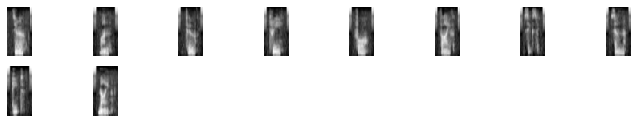

In [0]:
plt.figure(figsize=(12,2))
for pos in range(len(dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

## All done : Let's Train a Neural Network!

(please go to the '_Learn' Speech Recognition notebook : The dataset preparation for the numbers is done...

----------


### Extra! : Create 'animals' datasets

In [0]:
chu.download('http://redcatlabs.com/downloads/'
             +'deep-learning-workshop/notebooks/2-CNN/8-Speech/'
             +'data-animals-sounds.tar.gz')

Uncompressing .tar.gz : './data-animals-sounds.tar.gz'
'.' now contains data


In [0]:
! tar -xzf data-animals-sounds.tar.gz



In [0]:
! ls -l 

total 440
drwxr-xr-x 6 root root   4096 Feb 11 05:03 colab_helper
drwxr-xr-x 5 root root   4096 Feb 11 05:04 data
-rw-r--r-- 1 root root 435912 Feb 11 05:04 data-animals-sounds.tar.gz
drwxr-xr-x 1 root root   4096 Feb  5 18:37 sample_data


In [0]:
# First a training set
split_all_combined_files_into_wavs(prefix='animals')
create_dataset_from_folders('animals')

Splitting animals_phone_en-UK_m_Martin00.wav
Splitting animals_phone_en-UK_m_Martin01.wav
Splitting animals_phone_en-UK_m_Martin02.wav
Splitting animals_phone_en-UK_m_Martin03.wav
Splitting animals_phone_en-UK_m_Martin04.wav
Created dataset : data/animals.pkl


In [0]:
# And then some ad-hoc test cases
test_prefix = 'animals' +'-test'
create_dataset_from_adhoc_wavs(test_prefix)

Adding : cat_dog_fox_bird # 0 : (0,82)
Adding : cat_dog_fox_bird # 1 : (105,183)
Adding : cat_dog_fox_bird # 2 : (210,295)
Adding : cat_dog_fox_bird # 3 : (319,395)
Created dataset : data/animals-test.pkl


In [0]:
audio_playback_widget( os.path.join('data', test_prefix, 'cat_dog_fox_bird.wav') )

Now see whether we can learn the 'animal' words using the 'numbers' network...